In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import cv2
import json


import nibabel as nib
import pydicom

In [7]:
class reading_orignal_data:
    
    def __init__(self, MAIN_PATH,SUB_PATH={"CT_PATH":'/CT/',"RT_PATH":'/RTStruct/',}):

        self.INPUT_DIRECTORY = sorted(glob.glob(MAIN_PATH))
        self.PTV_IMAGES = []
        self.CT_SCAN_IMAGES = []

        for frakDir in self.INPUT_DIRECTORY: 

            ctDir     = frakDir + SUB_PATH["CT_PATH"]

            StructDicomFileName = glob.glob(frakDir+ SUB_PATH["RT_PATH"]+ '/*')[0]
            roiId=next((roi[0] for roi in self.displayStructureIDs(StructDicomFileName) if roi[1].lower() == "ptv"),None)
    
            if roiId !=None:
                _,ct = self.readDICOM3D(ctDir)
                cnt  = self.drawContours(ct.shape,roiId,ctDir,StructDicomFileName)

                cnt[cnt>0] = 1

                self.PTV_IMAGES.append(cnt)
                self.CT_SCAN_IMAGES.append(ct)

    def readDICOM3D(self,DICOM_DIR):
        dicomFiles = [file for file in os.listdir(DICOM_DIR) if file.endswith('dcm') and file.startswith('CT')]
        dicoms = []
        for file in dicomFiles:
            ds = pydicom.dcmread(DICOM_DIR+file)
            dicoms.append((DICOM_DIR+file,int(ds[0x0020,0x0013].value)))
        dicoms = sorted(dicoms, key=lambda x: x[1])

        im3D = []
        slicePositions = []
        for d in dicoms:
            ds = pydicom.dcmread(d[0])
            slicePositions.append(ds.ImagePositionPatient[2])
            im3D.append(ds.pixel_array)
    
        im3D = np.asarray(im3D,dtype=np.int16)
        im3D = np.swapaxes(im3D,0,1)
        im3D = np.swapaxes(im3D,1,2)

        ds = pydicom.dcmread(dicoms[0][0])
        CTOrigin = ds.ImagePositionPatient
        CTPixelSize = ds.PixelSpacing
        CTSliceThickness = ds.SliceThickness

        grid = (np.arange(CTOrigin[1],CTOrigin[1]+CTPixelSize[1]*im3D.shape[0],CTPixelSize[1]),
                np.arange(CTOrigin[0],CTOrigin[0]+CTPixelSize[0]*im3D.shape[1],CTPixelSize[0]),
                np.asarray(slicePositions,dtype=np.float64))
    
        return grid,im3D
    
    def displayStructureIDs(self,structuresFile):
        ROINumbers = []
        ds = pydicom.dcmread(structuresFile)
        for _,struct in enumerate(ds.StructureSetROISequence):
            ROINumbers.append((struct.ROINumber,struct.ROIName))
        return ROINumbers
    
    def drawContours(self,imSize,roiID,pathToCT,structuresDicomFileName):

        ds = pydicom.dcmread(structuresDicomFileName)

        roiNumbers = [dum.ROINumber for dum in ds.StructureSetROISequence]
        structID = roiNumbers.index(roiID)
    

        assert ds.SOPClassUID == "1.2.840.10008.5.1.4.1.1.481.3", "This is not a Dicom Structure file"

        ROI = [
            ds.ROIContourSequence[u].ContourSequence for u in range(len(ds.ROIContourSequence)) 
                if ds.ROIContourSequence[u].ReferencedROINumber == ds.StructureSetROISequence[structID].ROINumber
        ][0]

        positions = []
        CTs = glob.glob(pathToCT + '/CT*.dcm')
        for fname in CTs:
            ctds = pydicom.dcmread(fname)
            positions.append((ctds.ImagePositionPatient[2],fname)) 
            
        positions = sorted(positions, key=lambda x: x[0])  
        delta = positions[1][0] - positions[0][0]

        dum = np.zeros(imSize,dtype=np.uint8)
    
        for seq in ROI:
            points = np.swapaxes(np.reshape(seq.ContourData,(-1,3)),0,1)
            pos = points[2,0]
            for p in positions:
                if abs(pos - p[0]) < delta/2:
                    fname = p[1]     
            dicImage = pydicom.dcmread(fname)
        

            M = np.zeros((3,3),dtype = np.float32)
            M[0,0] = dicImage[0x0020, 0x0037].value[1]* dicImage[0x0028, 0x0030].value[0]
            M[1,0] = dicImage[0x0020, 0x0037].value[0]* dicImage[0x0028, 0x0030].value[0]
            M[0,1] = dicImage[0x0020, 0x0037].value[4]* dicImage[0x0028, 0x0030].value[1]
            M[1,1] = dicImage[0x0020, 0x0037].value[3]* dicImage[0x0028, 0x0030].value[1]
            M[0,2] = dicImage[0x0020, 0x0032].value[0]
            M[1,2] = dicImage[0x0020, 0x0032].value[1]
            M[2,2] = 1.0
        
            M = np.linalg.inv(M)
            points[2,:].fill(1)
            points = np.dot(M,points)[:2,:]

            big = int(ds.StructureSetROISequence[structID].ROINumber) # 255
            CTSlice = int(dicImage[0x0020,0x0013].value)-1            # numery sliców w Dicom startują od 1
            dum2D = np.zeros(imSize[0:2],dtype=np.uint8)
            for id in range(points.shape[1]-1):
                cv2.line(dum2D,(int(points[1,id]),int(points[0,id])),(int(points[1,id+1]),int(points[0,id+1])),big,1)
            cv2.line(dum2D,(int(points[1,points.shape[1]-1]),int(points[0,points.shape[1]-1])),(int(points[1,0]),int(points[0,0])),big,1)

            dum[dum2D!=0,CTSlice] = dum2D[dum2D!=0]
        
        for sl in range(dum.shape[2]):
            im_flood_fill = dum[...,sl].copy()
            h, w = dum.shape[:2]
            mask = np.zeros((h + 2, w + 2), np.uint8)
            im_flood_fill = im_flood_fill.astype("uint8")
            cv2.floodFill(im_flood_fill, mask, (0, 0), 128)
            dum[im_flood_fill!=128,sl] = big
        
        return dum
    
    @staticmethod
    def saveImage(PATH,LABEL,IMAGES):
        aff = np.eye(4)
        for INDEX,IMG in enumerate(IMAGES):
            baseName = PATH + LABEL + str(INDEX) + '_.nii.gz'
            niftiImage = nib.Nifti1Image(IMG, affine=aff)
            nib.save(niftiImage,baseName)
            
    def get_PTV_IMAGES(self):
        return self.PTV_IMAGES
    
    def get_CT_SCAN_IMAGES(self):
        return self.CT_SCAN_IMAGES

In [8]:
PTV_SAMPLES={}
for dir in next(os.walk('Samples/'))[1]:
    orignal_data_ob=reading_orignal_data(f'Samples/{dir}/frakcja_*')
    PTV_SAMPLES[dir]=orignal_data_ob.get_PTV_IMAGES()

In [9]:
def con_2d_image(binary_image):    
    
    center_of_mass=np.mean(np.where(binary_image),axis=1) 

    img_2d=binary_image[:,:,int(center_of_mass[2])]

    return img_2d

def calculate_image_detail (images_list,type=0):
    B2D_IMAGES=[]
    B2D_CENTER=[]
    B2D_SIZE=[]
    if type==0:
        for key, images in images_list.items():
            for single_image in images:
                img=con_2d_image(single_image.copy())
                
                one_location=np.where(img)
                B2D_CENTER.append(np.mean(one_location,axis=1))
                B2D_SIZE.append([
                    [np.min(one_location[i]) for i in range(2)],
                    [np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)]
                ])
                B2D_IMAGES.append(img)
        return B2D_IMAGES, B2D_CENTER, B2D_SIZE
    else:
        for img in images_list:
            one_location=np.where(img)
            B2D_CENTER.append(np.mean(one_location,axis=1))
            B2D_SIZE.append([
                [np.min(one_location[i]) for i in range(2)],
                [np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)]
            ])
            B2D_IMAGES.append(img)
        return B2D_CENTER, B2D_SIZE

# Step 1

Each 2d bounding box has horizontal and vertical size. Find the biggest horizontal (or vertical, it is up to you) size and scale all the remaining 2d images so that all bounding boxes have the same horizontal (or vertical) size

In [14]:
BINARY_2D_IMAGES, BINARY_2D_CENTER, BINARY_2D_SIZE= calculate_image_detail(PTV_SAMPLES,0)

In [11]:
# print("MIN [Y,X]: ",np.min(BINARY_2D_SIZE,axis=0))
# print("MAX [Y,X]: ",np.max(BINARY_2D_SIZE,axis=0))
# print(" Y: ",np.max(BINARY_2D_SIZE,axis=0)[1][1])

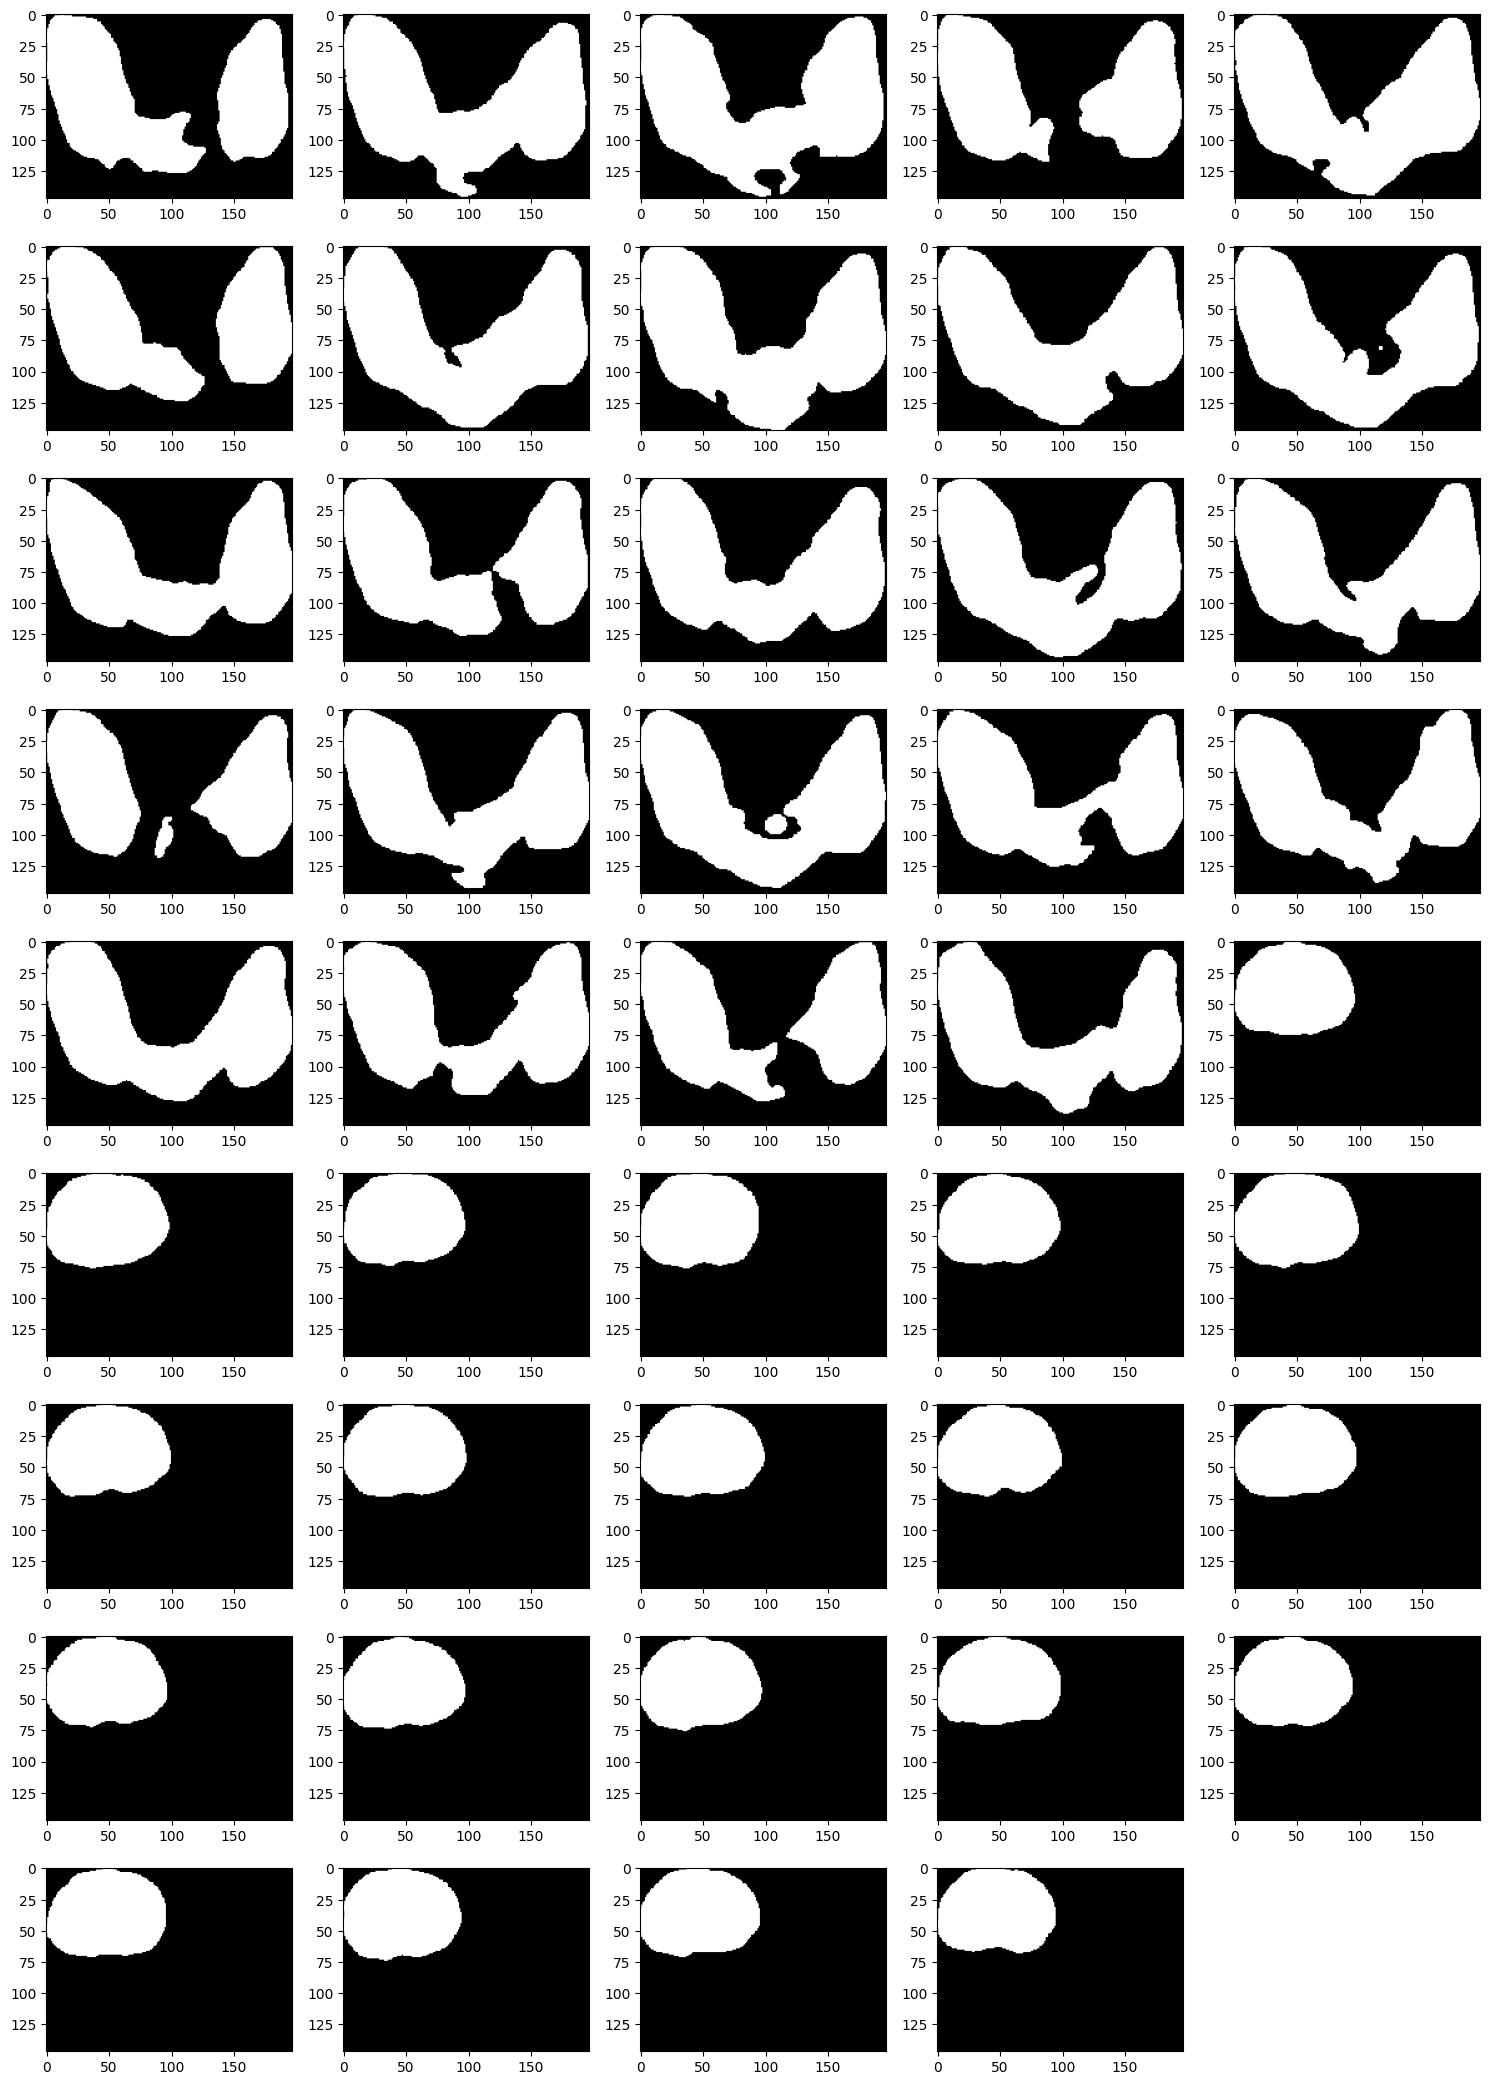

In [22]:
fig, axs = plt.subplots(9,5,figsize=(15,21))

MAX_X=np.max(BINARY_2D_SIZE,axis=0)[1][1]
MAX_Y=np.max(BINARY_2D_SIZE,axis=0)[1][0]

NEW_BINARY_2D_IMAGES=[]


for index, img in enumerate(BINARY_2D_IMAGES):
    ax=axs.flat[index]
    
    MIN_Y,MIN_X=BINARY_2D_SIZE[index][0]
    
    WIDTH_Y=BINARY_2D_SIZE[index][1][0]

    
    # Reverse comment for two below line it will find the biggest horizontal (or vertical)
    # img = img[MIN_Y:MIN_Y+WIDTH_Y,MIN_X:MIN_X+MAX_X]  # biggest for one axis 
    img = img[MIN_Y:MIN_Y+MAX_Y,MIN_X:MIN_X+MAX_X]      # biggest for both axis
    
    NEW_BINARY_2D_IMAGES.append(img)
    
    
    ax.imshow(img,cmap="gray")
    # ax.axis("off")
    
fig.delaxes(axs[8][4])
fig.tight_layout()

# Step 2

In [18]:
NEW_BINARY_2D_CENTER, NEW_BINARY_2D_SIZE= calculate_image_detail(NEW_BINARY_2D_IMAGES,1)

# Remaining Steps

In [ ]:
# Then, define a fixed size image such that a biggest bounding box can be fit inside it 
# (so you must know both the biggest horizontal and vertical size among allbounding boxes
# but the rescaled bounding boxes will have the same only one size of the two: horizontal and vertical)


# Finally, generate fixed size images by inserting into them rescaled bounding boxes in such a way that centers of mass of each 
# bounding box is always in the same pixel of the fixes size image

# I do not understand them fully :(
# I confused with [rescaled] word, it means make the bladder bigger?

# My Solution

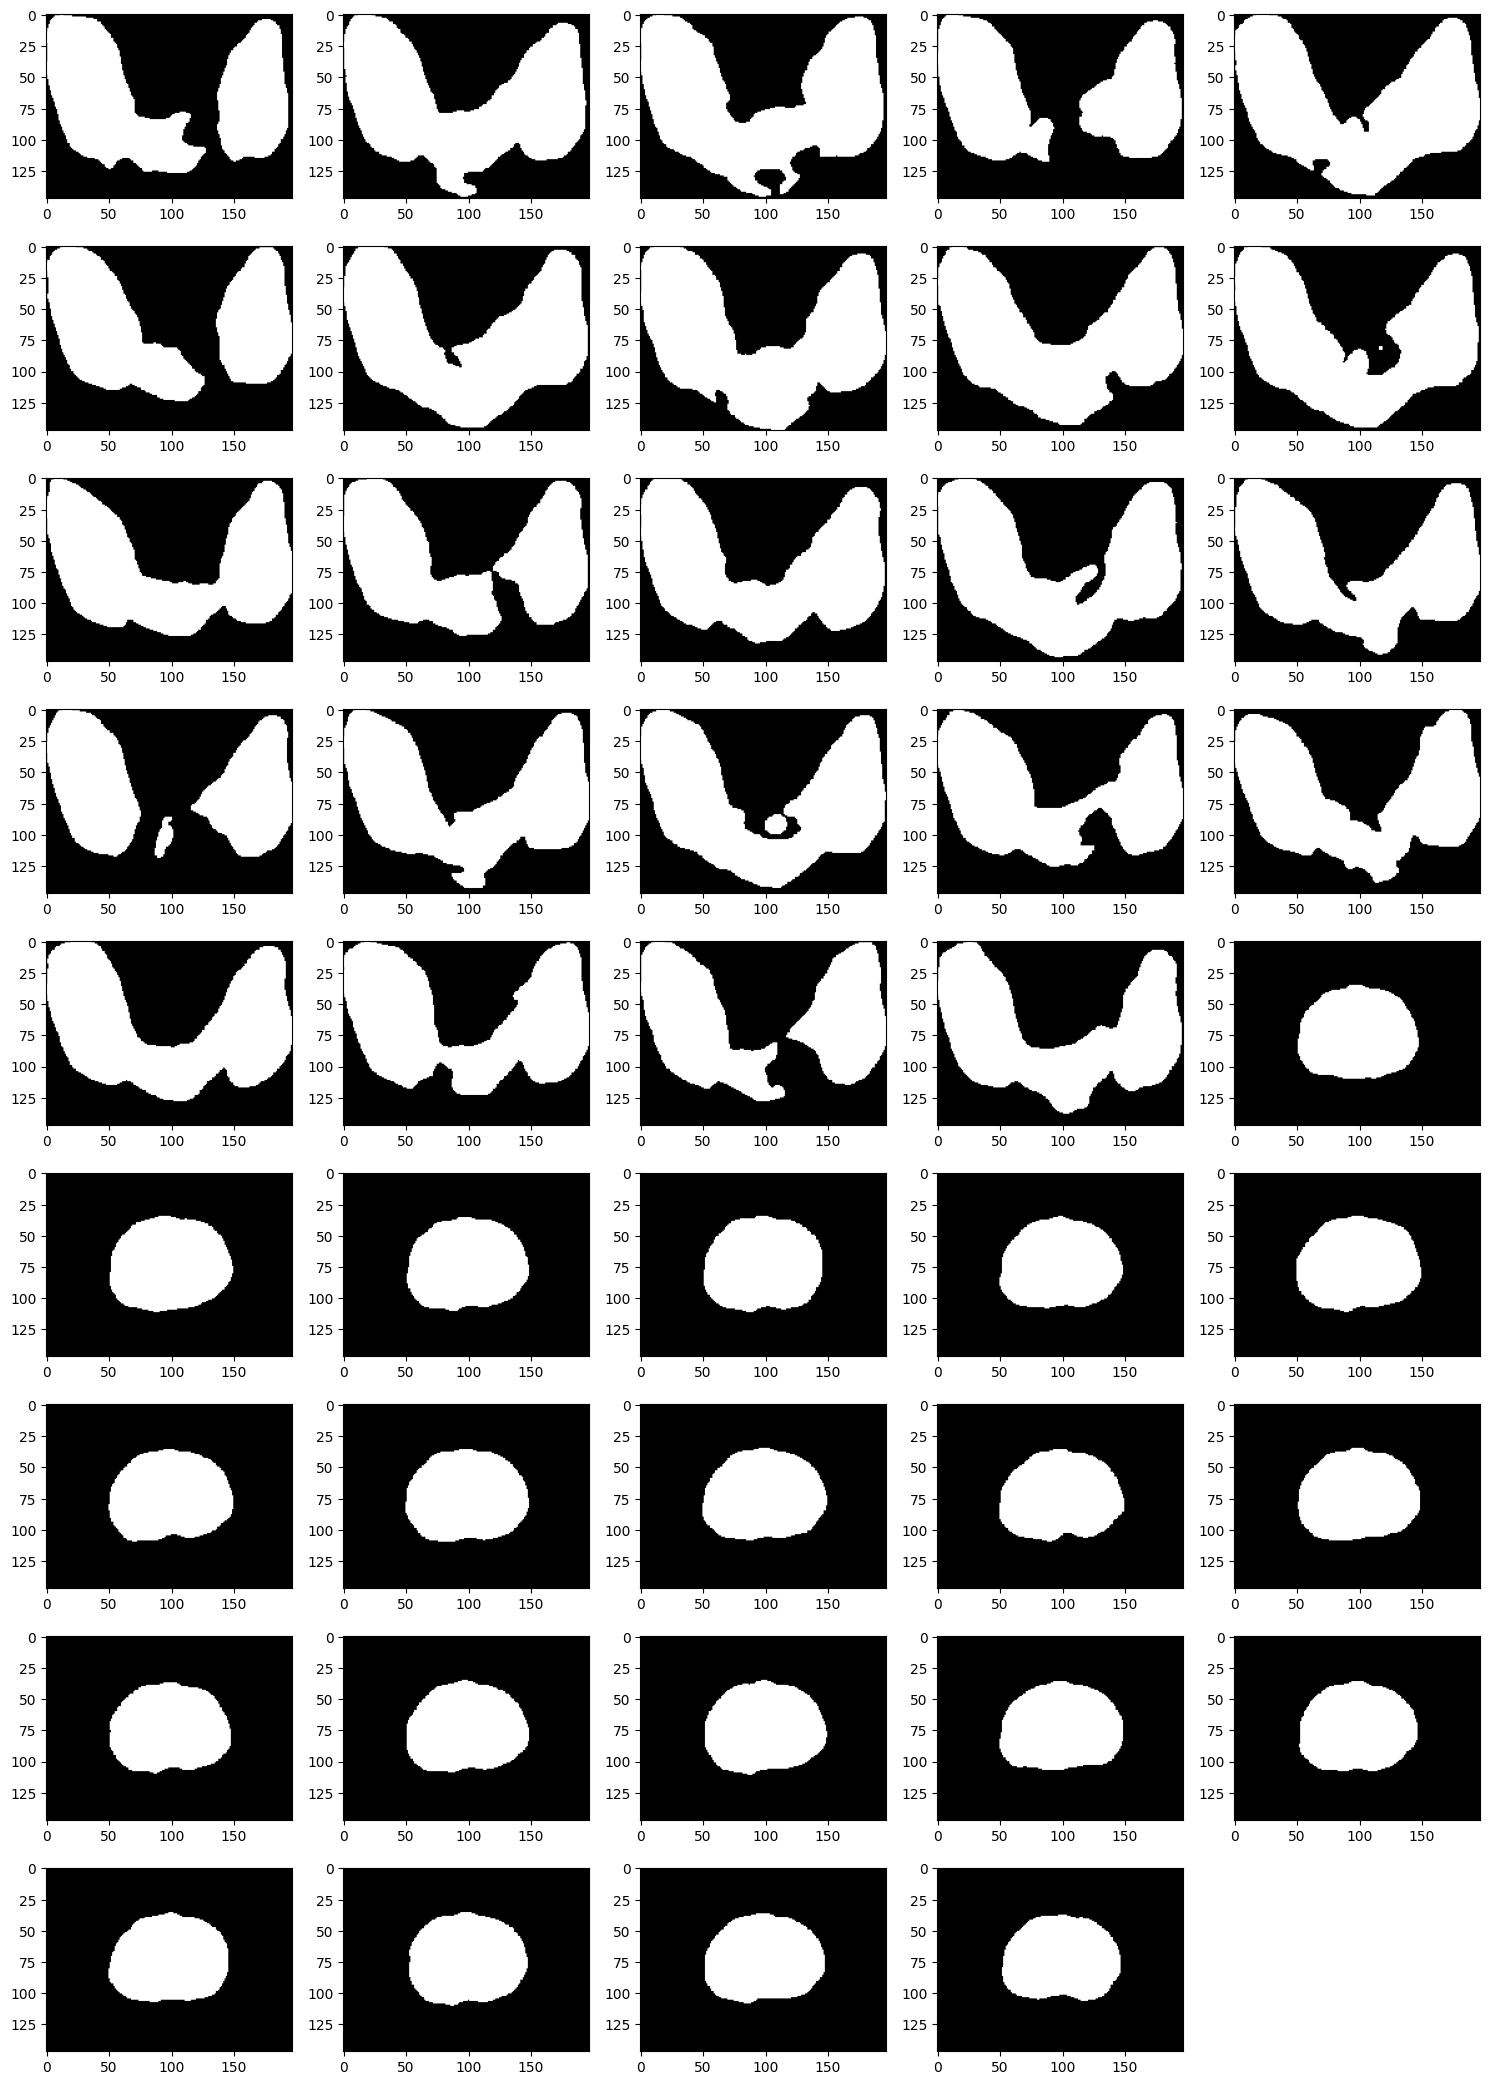

In [21]:
#all the images have the same size with original shape size

fig, axs = plt.subplots(9,5,figsize=(15,21))

for index, img in enumerate(NEW_BINARY_2D_IMAGES):
    ax=axs.flat[index]
    
    if index>23:
                
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            contour = contours[0]  # Assuming there is only one contour
            M = cv2.moments(contour)
            centroid_x = int(M['m10'] / M['m00'])
            centroid_y = int(M['m01'] / M['m00'])
            
            # Get the dimensions of the image
            height, width = img.shape
            
            # Calculate the translation required to move the centroid to the center of the image
            translation_x = width // 2 - centroid_x
            translation_y = height // 2 - centroid_y
            
            # Apply the translation to the contour
            contour_centered = contour + [translation_x, translation_y]
            
            # Create a new binary image with the centered object
            new_img = np.zeros_like(img)
            cv2.drawContours(new_img, [contour_centered], -1, 1, thickness=cv2.FILLED)
            ax.imshow(new_img,cmap="gray")
        
    else:
        ax.imshow(img,cmap="gray")
    # ax.axis("off")
    
fig.delaxes(axs[8][4])
fig.tight_layout()


In [ ]:
# def scaling_image(image,scaling_factor = 0.5):
    
#     # Find contours in the binary image
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Assuming there is only one contour (the object of interest)
#     if contours:
#         # Get the bounding box of the contour
#         x, y, w, h = cv2.boundingRect(contours[0])

#         # Calculate the center of the bounding box
#         center = (x + w // 2, y + h // 2)
        
#         print(center)

#         # Perform the scaling operation around the center of the bounding box
        
#         # print(image[y:y+h, x:x+w].shape)
#         scaled_image = cv2.resize(image[y:y+h, x:x+w], None, fx=scaling_factor, fy=1, interpolation=cv2.INTER_LINEAR)

#         # Calculate the translation required to keep the center of the bounding box unchanged after scaling
#         translation_x = int(center[0]* (1 - scaling_factor))
#         translation_y = int(center[1] * (1 - scaling_factor))

#         # Apply the translation to the scaled image
#         rows, cols = scaled_image.shape[:2]
#         translation_matrix = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
#         translated_image = cv2.warpAffine(scaled_image, translation_matrix, (cols, rows))

#         # print(image[y:y+h, x:x+w].shape,translated_image.shape)
#         # Create a binary mask for the scaled object
#         mask = np.zeros_like(image)
        
#         # print(y,y+translated_image.shape[0], x,x+translated_image.shape[1],np.unique(translated_image))
        
#         # print(scaled_image.shape,translated_image.shape)
#         mask[y:y+translated_image.shape[0], x:x+translated_image.shape[1]] = translated_image
            
#     return mask